# Asset Pricing--- Beta Estimation

组2 黄晶晶 喻清言 李子明

组内成员独立完成代码并交流问题，最后合作完成展示文稿

### 1. 理论介绍
#### β是什么？
根据Sharpe (1964), Lintner (1965), and Mossin (1966)提出的CAPM模型(Capital Asset Pricing Model)，单个资产的期望收益率由三部分共同决定：

1.无风险收益率（衡量了资产的时间价值）

2.不同市场的风险溢价（即市场的超额收益率）

3.β系数

即：
\begin{equation}
E(r_i)=r_f+\beta_i\times(E(r_M)-r_f)
\end{equation}
其中，β系数衡量了单个资产对于市场投资组合变化的风险敞口，反映了其对于市场变化的敏感度

#### 怎样基于历史数据估计β？
在本章节的操作中，我们对β的估计基于如下回归方程：
\begin{equation}
R_i=\alpha_i+\beta_i\times R_M+e_i
\end{equation}
其中，$R_i$为单个资产的超额收益率，$R_M$为市场超额收益率，基于单个资产时间序列数据的回归系数即为我们对单个资产$\beta_i$ 的估计，通过β绝对值大小的比较（一般为正）即可对单个资产对市场变化的敏感程度形成直观感知。

### 2. 前期准备
#### 2.1 导入库

In [1]:
import os
import pandas as pd
import numpy as np

# 基于从数据库加载数据的需要
import sqlite3

# 基于对测试数据回归的需要导入smf
import statsmodels.formula.api as smf
# 基于滚动窗口的需要导入RollingOLS
from statsmodels.regression.rolling import RollingOLS
# 基于并行化设计的需要导入joblib包
from joblib import Parallel, delayed

# 可视化
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format,percent_format
import seaborn as sns
import matplotlib.pyplot as plt

#### 2.2 数据准备
#### 我们需要哪些数据？
两个维度---日度、月度

每个维度---时间序列、公司代码、超额收益（单个及市场）、公司所属行业（月度可视化的需要）

数据来源：

1.从factors_ff3_monthly/daily 中获取市场超额收益的时间序列数据

2.从crsp_monthly/daily 中获取单个公司的公司代码、所属行业及超额收益的数据

#### 2.2.1 导入数据

#### ps：使用pd.read_csv函数读取数据时的参数
usecols:从原数据集中选出需要的列，形成列名列表

na_filter:读取数据时是否去掉na值,默认值为True,故不必再单独作去na值

parse_dates:需要解析为日期的列名列表（使用sql读取时也有此参数）

#### 导入方式1：sql导入

In [2]:
os.chdir(r'D:\Pycharm\tidyfinance')

In [3]:
# step1:创建连接
tidy_finance = sqlite3.connect(database="tidy_finance_python.sqlite")

In [41]:
# step2:使用sql语句从数据库加载数据
# 加载月度数据
# 1.factors_ff3_monthly数据
factors_ff3_monthly = pd.read_sql_query(sql='SELECT month, mkt_excess FROM factors_ff3_monthly',
                                        con=tidy_finance,parse_dates={'month'}).dropna() # parse_dates: 需要解析为日期的列名列表
factors_ff3_monthly

,month,mkt_excess
0,1960-01-01,-0.0698
1,1960-02-01,0.0117
2,1960-03-01,-0.0163
3,1960-04-01,-0.0171
4,1960-05-01,0.0312
...,...,...
751,2022-08-01,-0.0377
752,2022-09-01,-0.0935
753,2022-10-01,0.0783
754,2022-11-01,0.0460


In [42]:
# 2.crsp_monthly数据
crsp_monthly = pd.read_sql_query(sql='SELECT permno, month, industry, ret_excess FROM crsp_monthly',con=tidy_finance,parse_dates={'month'}).dropna()
crsp_monthly

,permno,month,industry,ret_excess
0,10000,1986-02-01,Manufacturing,-0.262443
1,10000,1986-03-01,Manufacturing,0.359385
2,10000,1986-04-01,Manufacturing,-0.103792
3,10000,1986-05-01,Manufacturing,-0.227556
4,10000,1986-06-01,Manufacturing,-0.010225
...,...,...,...,...
3326361,93436,2022-08-01,Public,-0.074389
3326362,93436,2022-09-01,Public,-0.039489
3326363,93436,2022-10-01,Public,-0.144468
3326364,93436,2022-11-01,Public,-0.147226


In [43]:
# 加载日度数据
# 1.factors_ff3_daily数据
factors_ff3_daily = pd.read_sql_query(sql='SELECT date, mkt_excess FROM factors_ff3_daily',con=tidy_finance,parse_dates={'date'}).dropna()
factors_ff3_daily

,date,mkt_excess
0,1960-01-04,-0.0003
1,1960-01-05,0.0078
2,1960-01-06,-0.0047
3,1960-01-07,-0.0065
4,1960-01-08,-0.0033
...,...,...
15853,2022-12-23,0.0051
15854,2022-12-27,-0.0051
15855,2022-12-28,-0.0123
15856,2022-12-29,0.0187


In [44]:
# 2.crsp_daily数据
crsp_daily = pd.read_sql_query(sql='SELECT permno, month, date, ret_excess FROM crsp_daily',con=tidy_finance,parse_dates={'month','date'}).dropna()
crsp_daily

MemoryError: 

#### 导入方式2：读取csv文件（由于电脑运行内存问题，本文档采用这种方式）

In [4]:
# 使用pd.read_csv
# 月度数据
factors_ff3_monthly = pd.read_csv("factors_ff3_monthly.csv",
                                  usecols=['month','mkt_excess'],
                                  parse_dates=['month']) # 由于空间问题，部分文件存至D盘
factors_ff3_monthly

,month,mkt_excess
0,1960-01-01,-0.0698
1,1960-02-01,0.0117
2,1960-03-01,-0.0163
3,1960-04-01,-0.0171
4,1960-05-01,0.0312
...,...,...
751,2022-08-01,-0.0377
752,2022-09-01,-0.0935
753,2022-10-01,0.0783
754,2022-11-01,0.0460


In [5]:
crsp_monthly = pd.read_csv("crsp_monthly.csv",
                           usecols=['permno','month','industry','ret_excess'],
                           parse_dates=['month'])
crsp_monthly

,permno,month,industry,ret_excess
0,10000,1986-02-01,Manufacturing,-0.262443
1,10000,1986-03-01,Manufacturing,0.359385
2,10000,1986-04-01,Manufacturing,-0.103792
3,10000,1986-05-01,Manufacturing,-0.227556
4,10000,1986-06-01,Manufacturing,-0.010225
...,...,...,...,...
3326361,93436,2022-08-01,Public,-0.074389
3326362,93436,2022-09-01,Public,-0.039489
3326363,93436,2022-10-01,Public,-0.144468
3326364,93436,2022-11-01,Public,-0.147226


In [6]:
# 日度数据
factors_ff3_daily = pd.read_csv("factors_ff3_daily.csv", 
                               usecols=['date','mkt_excess'],
                               parse_dates=['date'])
factors_ff3_daily

,date,mkt_excess
0,1960-01-04,-0.0003
1,1960-01-05,0.0078
2,1960-01-06,-0.0047
3,1960-01-07,-0.0065
4,1960-01-08,-0.0033
...,...,...
15853,2022-12-23,0.0051
15854,2022-12-27,-0.0051
15855,2022-12-28,-0.0123
15856,2022-12-29,0.0187


In [7]:
crsp_daily = pd.read_csv("crsp_daily.csv", 
                        usecols=['permno','month','date','ret_excess'],
                        parse_dates=['month','date'])
crsp_daily

,permno,date,month,ret_excess
0,10000.0,1986-01-08,1986-01-01,-0.024640
1,10000.0,1986-01-09,1986-01-01,-0.000250
2,10000.0,1986-01-10,1986-01-01,-0.000250
3,10000.0,1986-01-13,1986-01-01,0.049750
4,10000.0,1986-01-14,1986-01-01,0.047369
...,...,...,...,...
71116730,93436.0,2022-12-23,2022-12-01,-0.017711
71116731,93436.0,2022-12-27,2022-12-01,-0.114249
71116732,93436.0,2022-12-28,2022-12-01,0.032929
71116733,93436.0,2022-12-29,2022-12-01,0.080667


#### 2.2.2 数据连接
即分别在月度、日度维度下对个股当月/当日的市场超额收益率作查询

In [8]:
# 月度数据
crsp_monthly = pd.merge(crsp_monthly,factors_ff3_monthly,how="left") # 由于默认按重复键连接，故未列出on参数；左连接实际起到查询作用
crsp_monthly

,permno,month,industry,ret_excess,mkt_excess
0,10000,1986-02-01,Manufacturing,-0.262443,0.0713
1,10000,1986-03-01,Manufacturing,0.359385,0.0488
2,10000,1986-04-01,Manufacturing,-0.103792,-0.0131
3,10000,1986-05-01,Manufacturing,-0.227556,0.0462
4,10000,1986-06-01,Manufacturing,-0.010225,0.0103
...,...,...,...,...,...
3326361,93436,2022-08-01,Public,-0.074389,-0.0377
3326362,93436,2022-09-01,Public,-0.039489,-0.0935
3326363,93436,2022-10-01,Public,-0.144468,0.0783
3326364,93436,2022-11-01,Public,-0.147226,0.0460


In [9]:
# 日度数据
crsp_daily = pd.merge(crsp_daily,factors_ff3_daily,how="left")
crsp_daily

,permno,date,month,ret_excess,mkt_excess
0,10000.0,1986-01-08,1986-01-01,-0.024640,-0.0216
1,10000.0,1986-01-09,1986-01-01,-0.000250,-0.0117
2,10000.0,1986-01-10,1986-01-01,-0.000250,-0.0002
3,10000.0,1986-01-13,1986-01-01,0.049750,0.0028
4,10000.0,1986-01-14,1986-01-01,0.047369,0.0001
...,...,...,...,...,...
71116730,93436.0,2022-12-23,2022-12-01,-0.017711,0.0051
71116731,93436.0,2022-12-27,2022-12-01,-0.114249,-0.0051
71116732,93436.0,2022-12-28,2022-12-01,0.032929,-0.0123
71116733,93436.0,2022-12-29,2022-12-01,0.080667,0.0187


#### 2.3 单个公司数据的测试
利用回归方程计算苹果公司（permno为14593）在整段时间区间上的β值

In [10]:
# 取出苹果公司的数据
apple = crsp_monthly[crsp_monthly["permno"]==14593]
# 作回归
apple_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess",
    data=apple)
  .fit())
# 结果展示
apple_beta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ret_excess   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     155.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.88e-31
Time:                        01:12:32   Log-Likelihood:                 384.99
No. Observations:                 504   AIC:                            -766.0
Df Residuals:                     502   BIC:                            -757.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0102      0.005      2.003      0.046       0.000       0.020
mkt_excess     1.3889      0.111     12.467      0.000       1.170       1.608
==============================================================================
Omnibus:                       19.632   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.358
Skew:                          -0.099   Prob(JB):                     8.58e-11
Kurtosis:                       4.473   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

即苹果公司在1981~2022年内β值约为1.4

In [11]:
apple

,permno,month,industry,ret_excess,mkt_excess
376052,14593,1981-01-01,Manufacturing,-0.180418,-0.0504
376053,14593,1981-02-01,Manufacturing,-0.072374,0.0057
376054,14593,1981-03-01,Manufacturing,-0.087217,0.0356
376055,14593,1981-04-01,Manufacturing,0.146560,-0.0211
376056,14593,1981-05-01,Manufacturing,0.152974,0.0011
...,...,...,...,...,...
376551,14593,2022-08-01,Manufacturing,-0.033037,-0.0377
376552,14593,2022-09-01,Manufacturing,-0.122877,-0.0935
376553,14593,2022-10-01,Manufacturing,0.107251,0.0783
376554,14593,2022-11-01,Manufacturing,-0.036029,0.0460


### 3. 月度与日度的β估计
#### 3.1 滚动窗口的设计
#### 什么是滚动窗口？
滚动窗口法是一个在处理连续数据流时经常使用的方法，不同于以上苹果公司的例子，现在我们需要对全部数据集的每一个时间基于该时间的历史数据作β估计。假设我们每次用于估计β的窗口长度固定（即每次都使用固定的n个月的历史数据），那整个的预测过程就相当于在滚动这个窗口，每次用这个窗口框住固定长度的历史数据去估计当前时点的β值。

需要注意的是，滚动窗口可以固定长度，也可以随着时间的推移扩展式滚动。

前者的好处是保证了用于当前β估计的数据时效性，不会使用过于久远的数据；而后者则是始终保持第一个数据不变，随着时间的推移逐步扩展使用的数据长度。
#### 怎样在python中使用滚动窗口法估计β？
使用的函数：RollingOLS.from_formula()

#### 函数用法：
RollingOLS.from_formula(
    formula,
    data,
    window,
    min_nobs
)

formula:指定模型公式

data:指定数据

window:滚动窗口的长度

min_nobs:指定了在存在缺失值的情况下，估计模型所需的最小观测值数量。

#### 滚动窗口的设计

In [12]:
def roll_capm_estimation(data,window_size,min_obs):
    if "date" in data.columns:
        data.sort_values( 'date', inplace=True)
    else:
        data.sort_values( 'month', inplace=True) # 月度、日度数据通用
    rolling_params = (RollingOLS.from_formula(formula="ret_excess ~ mkt_excess",
      data=data,window=window_size,min_nobs=min_obs).fit() 
    .params["mkt_excess"])
    rolling_params.index = data.index
    return rolling_params

#### 3.2 滚动窗口设计的测试
现对Apple, Microsoft, Tesla以及Berkshire Hathaway四家公司的β值作滚动估计，并将结果可视化
#### 测试数据的准备

In [13]:
examples = pd.DataFrame({
  "permno": [14593, 10107, 93436, 17778],
  "company": ["Apple", "Microsoft", 
              "Tesla", "Berkshire Hathaway"]
})

# 作这四家公司数据的查询
test = pd.merge(examples,crsp_monthly,how="left")
test

,permno,company,month,industry,ret_excess,mkt_excess
0,14593,Apple,1981-01-01,Manufacturing,-0.180418,-0.0504
1,14593,Apple,1981-02-01,Manufacturing,-0.072374,0.0057
2,14593,Apple,1981-03-01,Manufacturing,-0.087217,0.0356
3,14593,Apple,1981-04-01,Manufacturing,0.146560,-0.0211
4,14593,Apple,1981-05-01,Manufacturing,0.152974,0.0011
...,...,...,...,...,...,...
1641,17778,Berkshire Hathaway,2022-08-01,Finance,-0.069184,-0.0377
1642,17778,Berkshire Hathaway,2022-09-01,Finance,-0.037119,-0.0935
1643,17778,Berkshire Hathaway,2022-10-01,Finance,0.092615,0.0783
1644,17778,Berkshire Hathaway,2022-11-01,Finance,0.076260,0.0460


#### 估计β值

In [14]:
# 参数设置
window_size = 60
min_obs = 48

# 滚动估计
beta_test = test.groupby(test["permno"]).apply(lambda x:x.assign(beta = roll_capm_estimation(x,window_size,min_obs))).dropna()
beta_test

permno    company      month  industry  ret_excess  mkt_excess  \
permno                                                                        
10107  563    10107  Microsoft 1991-03-01  Services    0.018492      0.0265   
       564    10107  Microsoft 1991-04-01  Services   -0.072438     -0.0028   
       565    10107  Microsoft 1991-05-01  Services    0.103886      0.0365   
       566    10107  Microsoft 1991-06-01  Services   -0.073107     -0.0494   
       567    10107  Microsoft 1991-07-01  Services    0.073999      0.0424   
...             ...        ...        ...       ...         ...         ...   
93436  1090   93436      Tesla 2022-08-01    Public   -0.074389     -0.0377   
       1091   93436      Tesla 2022-09-01    Public   -0.039489     -0.0935   
       1092   93436      Tesla 2022-10-01    Public   -0.144468      0.0783   
       1093   93436      Tesla 2022-11-01    Public   -0.147226      0.0460   
       1094   93436      Tesla 2022-12-01    Public   -0.370634     -0.0641   

                 beta  
permno                 
10107  563   1.411268  
       564   1.431428  
       565   1.441396  
       566   1.460013  
       567   1.443456  
...               ...  
93436  1090  2.158801  
       1091  2.100328  
       1092  1.972512  
       1093  1.936273  
       1094  2.047437  

[1410 rows x 7 columns]

#### 结果可视化

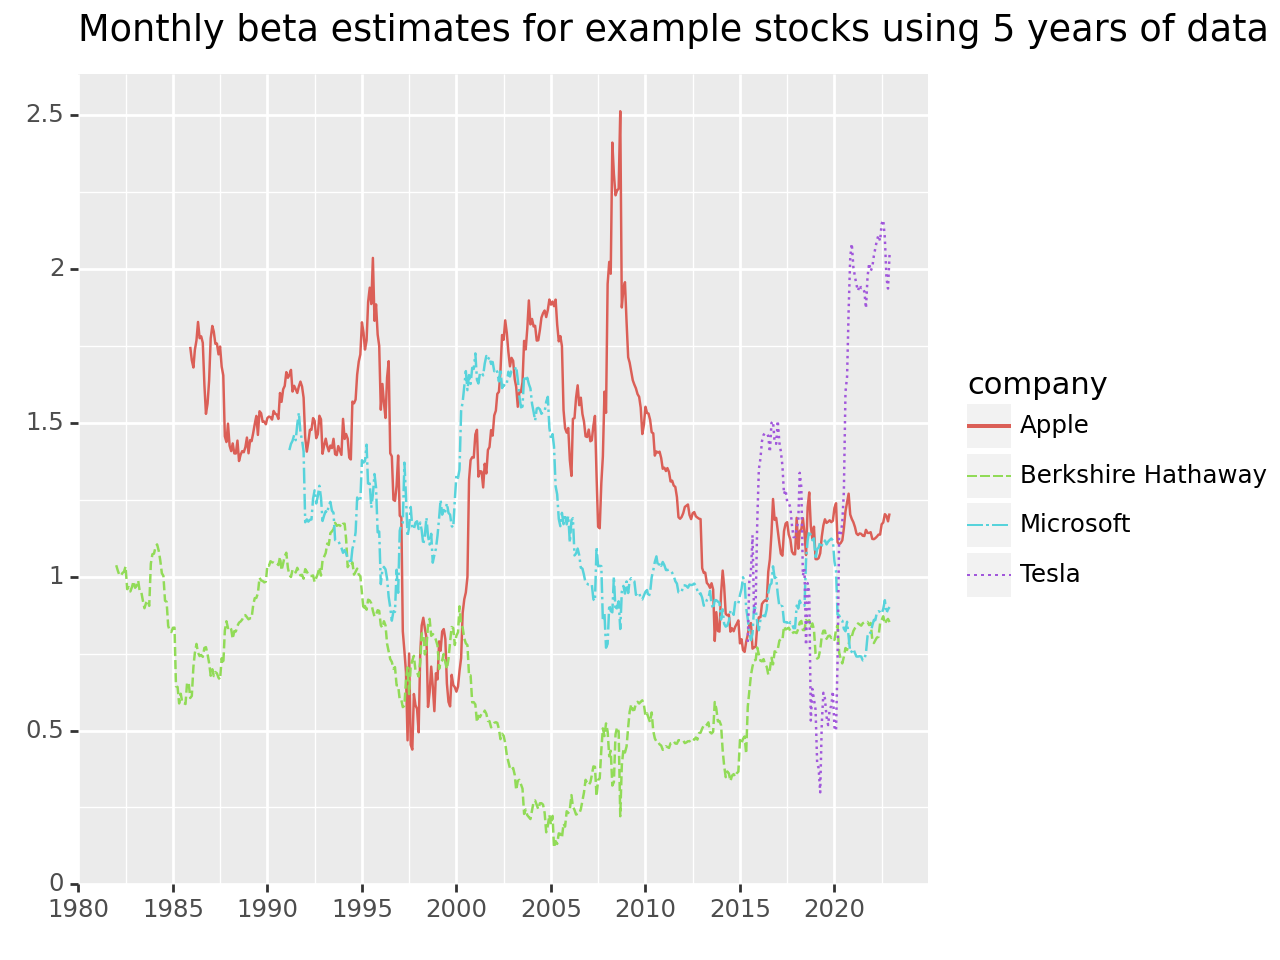

In [15]:
figure_test = (ggplot(beta_test,aes(x="month",y="beta",color="company",linetype="company"))+
geom_line()+
labs(x="", y="",
      title="Monthly beta estimates for example stocks using 5 years of data")+
scale_x_datetime(breaks=date_breaks("5 years"),
                labels=date_format("%Y")))
figure_test.draw()

#### 3.3 并行化的设计
#### 什么是并行化？
并行化指的是利用计算机的多个核心处理器，将一个程序拆分成多个子任务，这些子任务可以在多个CPU上同时运行，从而提高程序的执行速度。

在本章节中，要对全部个股作β的滚动估计，不同个股的β估计之间是没有联系、可以并行处理的。

#### 本章节使用的并行化处理函数是什么？
joblib包中的Parallel、delayed

#### 函数参数解释
    Parallel(

       n_jobs=default(None),  核的个数:最大可选-1，即除一个核外，其它核都在进行并行化任务
    
       backend=default(None), 在Python中，有很多库可以用来进行并行计算，例如 multiprocessing, joblib, dask 等这里的 "ParallelBackendBase instance or None, default: 'loky'" 是在说你可以指定一个并行计算的后端实现, 如果不指定，默认使用 'loky' 这个后端。
   
       return_as='list', # 可选list或者generator，后者可以随时返回可用值而不用等所有结果都运算完。
   
       verbose=default(0), # 如果这个参数不是零，那么程序会打印出进度信息。
    
       timeout=None, # 超时限制通常用于控制一项任务在特定时间内完成。如果在指定的时间内任务没有完成，那么会抛出一个超时错（TimeoutError）
    )
    
    delayed( )：将函数调用推迟到并行处理的过程中，确保在每个进程中只导入一次函数，并在需要时进行调用。
    
#### ps: 本部分使用到的其它函数：
transform函数：

通常情况下，transform函数接受一个函数作为参数，该函数定义了如何对可迭代对象中的每个元素进行转换。这个函数将应用于可迭代对象中的每个元素，并返回转换后的结果。
 

In [16]:
# 首先定义一个针对每一个permno的函数（即子任务内部的处理）
def roll_capm_estimation_for_joblib(name,group):
    beta = roll_capm_estimation(group,window_size,min_obs)
    result = pd.DataFrame()
    result["month"] = group["month"]
    result["permno"] = group["permno"]
    result["beta"] = beta
    try:
        result["date"] = group["date"].values
        result = result[
        (result.groupby("month")["date"]
          .transform("max")) == result["date"]]  # 对于日度数据，只保留了每月最后一天的值
    except(KeyError):
        pass
    result.dropna()
    return result

#### 3.4 月度β的估计
由于rollingOLS函数有内置条件（数据条数多于min_obs)，现基于此对数据进行筛选（下面日度数据亦同）

#### 查询所使用的函数：query
在筛选数据时，query函数的作用是根据指定的条件筛选数据。它接受一个查询语句作为参数，并返回满足查询条件的结果集。查询语句通常包含一些过滤条件，用于指定筛选数据的规则。

In [17]:
# 月度数据筛选
valid_permnos = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
grouped_data = (crsp_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .dropna()
  .groupby("permno")
)

In [18]:
# 月度β的计算
beta_monthly = (pd.concat(Parallel(n_jobs=-3,
        backend="loky",
        verbose=8)(delayed(roll_capm_estimation_for_joblib)(name,group)for name,group in grouped_data)).dropna())
beta_monthly

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-3)]: Done  36 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-3)]: Done  77 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-3)]: Done 144 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done 364 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-3)]: Done 900 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-3)]: Done 1516 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-3)]: Done 2196 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-3)]: Done 2956 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-3)]: Done 3780 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-3)]: Done 4684 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-3)]: Done 5652 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-3)]: Done 6700 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-3)]: Done 7812 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-3)]: Done 9004 tasks      | e

,month,permno,beta
59,1991-01-01,10001,0.097436
60,1991-02-01,10001,0.094800
61,1991-03-01,10001,0.089890
62,1991-04-01,10001,0.088488
63,1991-05-01,10001,0.091946
...,...,...,...
2995444,2022-08-01,93436,2.158801
2995445,2022-09-01,93436,2.100328
2995446,2022-10-01,93436,1.972512
2995447,2022-11-01,93436,1.936273


In [19]:
beta_monthly.rename(columns={'beta':'beta_monthly'},inplace=True)
beta_monthly

,month,permno,beta_monthly
59,1991-01-01,10001,0.097436
60,1991-02-01,10001,0.094800
61,1991-03-01,10001,0.089890
62,1991-04-01,10001,0.088488
63,1991-05-01,10001,0.091946
...,...,...,...
2995444,2022-08-01,93436,2.158801
2995445,2022-09-01,93436,2.100328
2995446,2022-10-01,93436,1.972512
2995447,2022-11-01,93436,1.936273


#### 3.5 日度β的估计

In [20]:
window_size = 60
min_obs = 50

# 日度数据的筛选
valid_permnos2 = (crsp_daily
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
grouped_data_daily = (crsp_daily
  .merge(valid_permnos2, how="inner", on="permno")
  .dropna()
  .groupby("permno")
)

In [21]:
# 日度β的计算
beta_daily = (pd.concat(Parallel(n_jobs=-3,
        backend="loky",
        verbose=8)(delayed(roll_capm_estimation_for_joblib)(name,group)for name,group in grouped_data_daily)).dropna())
beta_daily.rename(columns={'beta':'beta_daily'},inplace=True)
beta_daily

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-3)]: Done  36 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-3)]: Done  77 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-3)]: Done 126 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 185 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-3)]: Done 252 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-3)]: Done 329 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-3)]: Done 414 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-3)]: Done 509 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-3)]: Done 612 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-3)]: Done 725 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-3)]: Done 846 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-3)]: Done 977 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-3)]: Done 1116 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-3)]: Done 1265 tasks      | elapsed:

,month,permno,beta_daily,date
78,1986-04-01,10000.0,0.005527,1986-04-30
99,1986-05-01,10000.0,0.003349,1986-05-30
120,1986-06-01,10000.0,-0.020345,1986-06-30
142,1986-07-01,10000.0,0.600559,1986-07-31
163,1986-08-01,10000.0,0.650888,1986-08-29
...,...,...,...,...
71112108,2022-08-01,93436.0,1.702458,2022-08-31
71112129,2022-09-01,93436.0,1.515607,2022-09-30
71112150,2022-10-01,93436.0,1.265084,2022-10-31
71112171,2022-11-01,93436.0,1.417427,2022-11-30


In [22]:
beta = (beta_monthly
  .get(["permno", "month", "beta_monthly"])
  .merge(beta_daily.get(["permno", "month", "beta_daily"]),
         how="outer",
         on=["permno", "month"])
)
beta

,permno,month,beta_monthly,beta_daily
0,10001.0,1991-01-01,0.097436,0.621683
1,10001.0,1991-02-01,0.094800,0.164431
2,10001.0,1991-03-01,0.089890,0.040938
3,10001.0,1991-04-01,0.088488,-0.150018
4,10001.0,1991-05-01,0.091946,-0.048594
...,...,...,...,...
3338935,93436.0,2015-01-01,NaN,1.660400
3338936,93436.0,2015-02-01,NaN,1.494448
3338937,93436.0,2015-03-01,NaN,1.211790
3338938,93436.0,2015-04-01,NaN,0.915710


### 4. β估计值的比较

#### 4.1 不同行业公司的β估计值比较

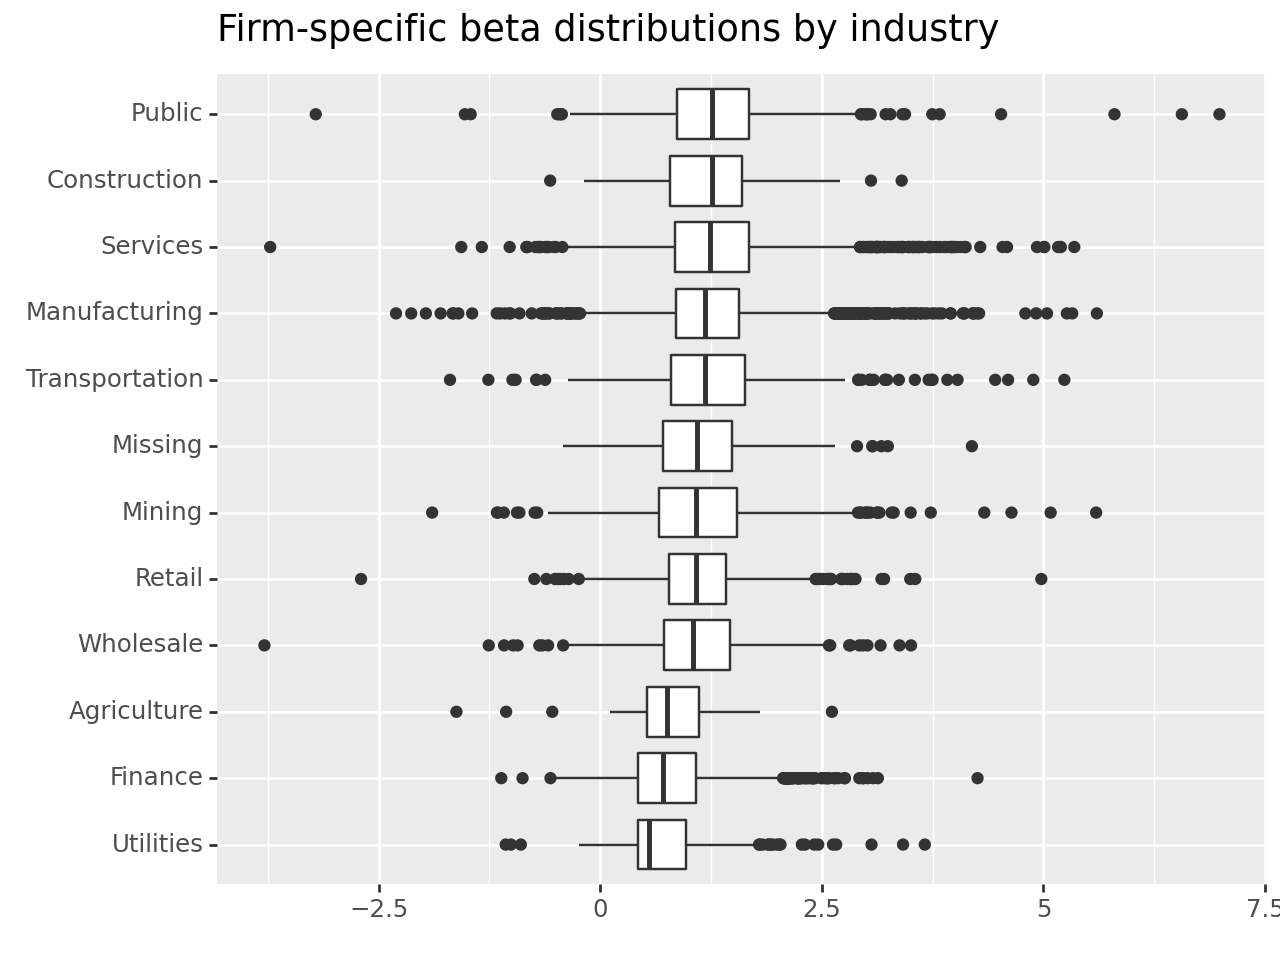

In [23]:
beta_industries = (beta_monthly
  .merge(crsp_monthly, how="inner", on=["permno", "month"])
  .dropna(subset="beta_monthly")
  .groupby(["industry","permno"])["beta_monthly"]
  .aggregate("mean")
  .reset_index()
)

industry_order = (beta_industries
  .groupby("industry")["beta_monthly"]
  .aggregate("median").sort_values()
  .index.tolist()
)

plot_beta_industries = (
  ggplot(beta_industries, 
         aes(x="industry", y="beta_monthly")) +
  geom_boxplot() +
  coord_flip() +
  scale_x_discrete(limits=industry_order) +
  labs(x="", y="", 
       title="Firm-specific beta distributions by industry")
)
plot_beta_industries.draw()

不同行业间的市场风险暴露没有明显差异
#### 4.2 不同时间β估计值比较

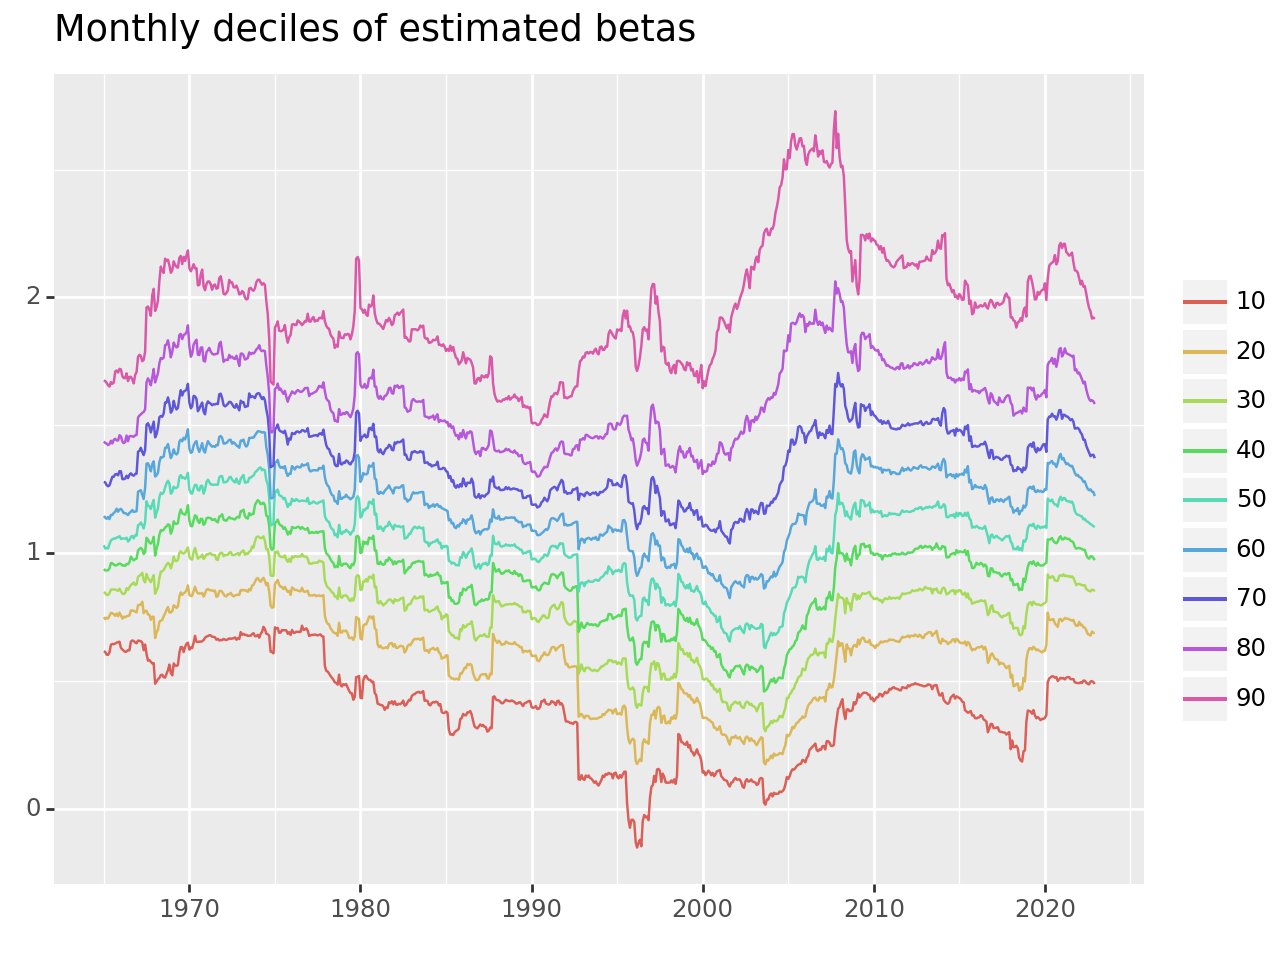

In [24]:
beta_quantiles = (beta_monthly
  .groupby("month")["beta_monthly"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_beta_quantiles = (
  ggplot(beta_quantiles, 
         aes(x="month", y="beta_monthly", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title="Monthly deciles of estimated betas")
)
plot_beta_quantiles.draw()

某些时间段β差异较大，而某些时间段差异较小；并且留意到某些时间段高组上升，低组下降，即公司对市场风险的暴露变大。
#### 4.3 日度和月度β估计值比较

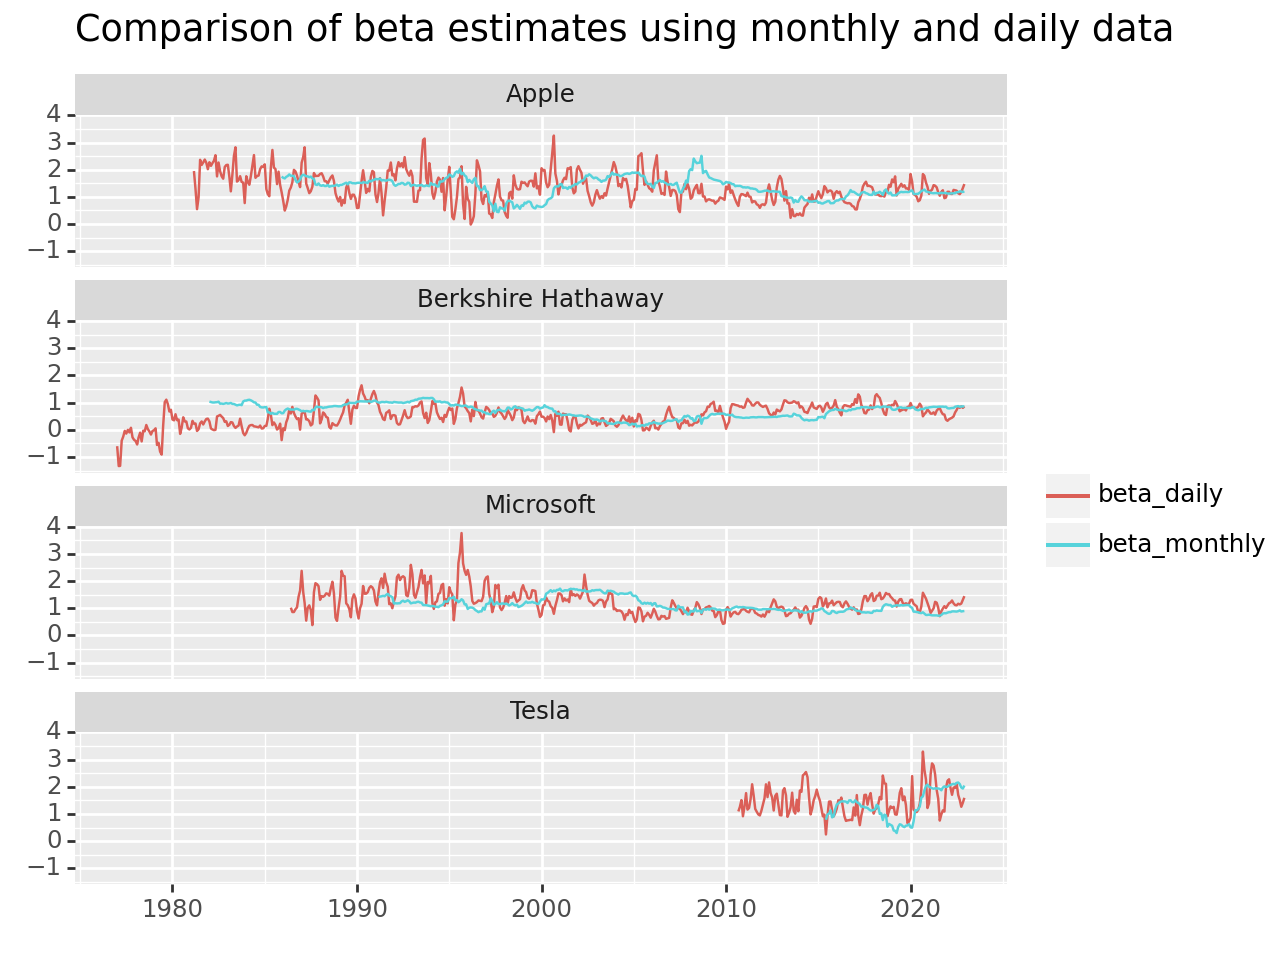

In [25]:
beta = (beta_monthly
  .get(["permno", "month", "beta_monthly"])
  .merge(beta_daily.get(["permno", "month", "beta_daily"]),
         how="outer",
         on=["permno", "month"])
)

beta_comparison = (beta
  .merge(examples, on="permno")
  .melt(id_vars=["permno", "month", "company"],
        value_vars=["beta_monthly", "beta_daily"],
        var_name="name", value_name="value")
  .dropna()
)

plot_beta_comparison = (
  ggplot(beta_comparison,
         aes(x="month", y="value", color="name")) +
  geom_line() +
  facet_wrap("~company", ncol=1) +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title=("Comparison of beta estimates using monthly "
              "and daily data"))
)
plot_beta_comparison.draw()

样本中日度与月度的估计值变化趋势基本一致，但是日度的波动更频繁  




将日度与月度的β估计值导出保存以备之后使用

In [26]:
beta.to_csv("beta.csv")
(beta
  .to_sql(
    name="beta", 
    con=tidy_finance, 
    if_exists="replace",
    index=False
  )
)

3338940

#### 4.4 稳健性检验
检验每个时间段有百分之多少的股票存在有效估计值

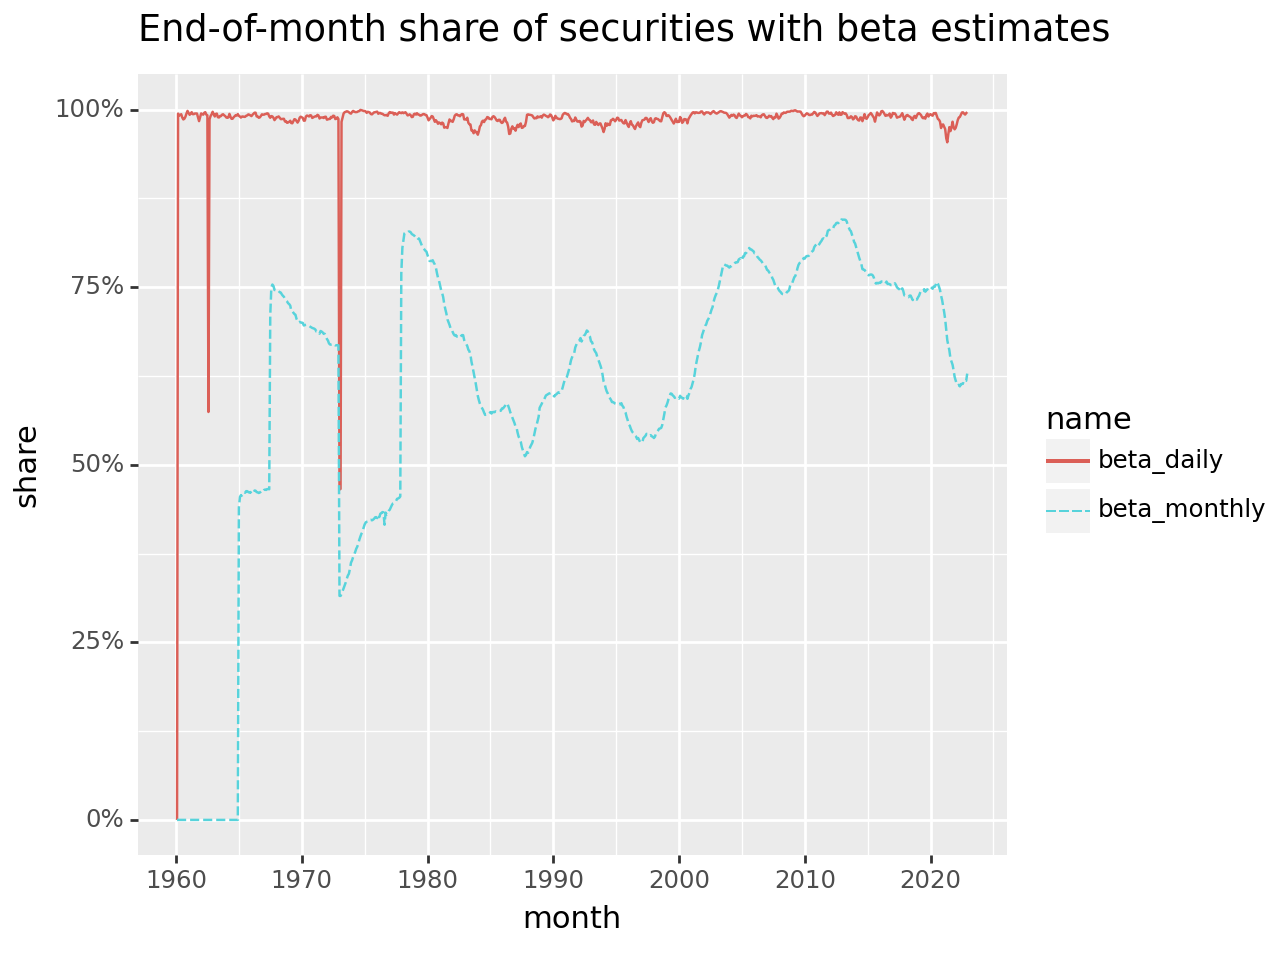

In [27]:
beta_long = (crsp_monthly
  .merge(beta, how="left", on=["permno", "month"])
  .melt(id_vars=["permno", "month"],
        value_vars=["beta_monthly", "beta_daily"],
        var_name="name", value_name="value")
  .groupby(["month", "name"])
  .aggregate(
    share=("value", lambda x: sum(~x.isna()) / len(x))
  )
  .reset_index()
)

plot_beta_long = (
  ggplot(beta_long, 
         aes(x="month", y="share", color="name", 
             linetype="name")) +
  geom_line() +
  scale_y_continuous(labels=percent_format()) +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x=None, y=None, color=None, linetype=None,
       title=("End-of-month share of securities with beta "
              "estimates"))
)
plot_beta_long.draw()

可见不考虑早期时间段的情况下，估计值的覆盖率相当高

可以观察日度和月度估计值的描述性统计尤其是其分位数

In [28]:
beta_long.groupby("name")["share"].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
beta_daily,755.0,0.985748,0.047797,0.0,0.985802,0.990375,0.993690,0.999573
beta_monthly,755.0,0.606505,0.213695,0.0,0.546678,0.668273,0.753688,0.845352


预期月度与日度的估计值应该是正相关的

In [29]:
beta.get(["beta_monthly", "beta_daily"]).corr()

,beta_monthly,beta_daily
beta_monthly,1.000000,0.314997
beta_daily,0.314997,1.000000


###  练习

#### 1、使用1年、3年和5年的数据根据​​每月数据计算beta估计值，并分别对返回数据施加10、28和48个月的最小观察次数。贝塔估计值的相关性有多强？

In [30]:
window_size = 12
min_obs = 10
# 更改数据窗口为1年，并需要至少10个月的数据来计算

valid_permnos_monthly_1 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_1 = (crsp_monthly
  .merge(valid_permnos_monthly_1, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_1 = (
    permno_groups_monthly_1
    .apply(lambda group: group.assign(beta_bymonth_1=roll_capm_estimation(group, window_size, min_obs)))
    .dropna()
)

In [31]:
window_size = 36
min_obs = 28
# 更改数据窗口为3年，并需要至少28个月的数据来计算

valid_permnos_monthly_2 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_2 = (crsp_monthly
  .merge(valid_permnos_monthly_2, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_2 = (
    permno_groups_monthly_2
    .apply(lambda group: group.assign(beta_bymonth_2=roll_capm_estimation(group, window_size, min_obs)))
    # 在所有分组上应用函数roll_capm_estimation
    .dropna()
)

In [33]:
# 合并以上通过不同时间窗口计算得到的beta值数据
estimated_betas = (beta_monthly
.merge(beta_monthly_1, how="inner", on=["permno", "month"])
.merge(beta_monthly_2, how="inner", on=["permno", "month"])
)
estimated_betas.rename(columns={'beta_monthly': 'beta_bymonth_3'}, inplace=True)

In [34]:
# 计算相关系数矩阵
estimated_betas.get(["beta_bymonth_1", "beta_bymonth_2", "beta_bymonth_3"]).corr()

,beta_bymonth_1,beta_bymonth_2,beta_bymonth_3
beta_bymonth_1,1.000000,0.571238,0.466984
beta_bymonth_2,0.571238,1.000000,0.826302
beta_bymonth_3,0.466984,0.826302,1.000000


#### 2、过滤掉贝塔系数为负的股票。这些股票是否经常表现出负贝塔值，或者它们是否类似于估计错误？

In [35]:
# 根据'permno'分组，然后使用all()函数筛选出每个分组中'beta_bymonth'存在小于0的行
filtered_beta_monthly = beta_monthly[beta_monthly['beta_monthly'] < 0]
filtered_beta_monthly.groupby('permno').count().sort_values('month',ascending=False)

,month,beta_monthly
permno,,
11593,191,191
70704,146,146
49322,145,145
64442,145,145
48072,143,143
...,...,...
77248,1,1
10596,1,1
77307,1,1


In [36]:
# 以下以代码为‘10001, 10002, 10011, 10021, 10028’的股票为例
permnos_have_negative_beta = pd.DataFrame({"permno": [10001, 10002, 10011, 10021, 10028]})
Negative_beta_example = (beta_monthly
  .merge(permnos_have_negative_beta, how="inner", on="permno")
  .dropna()
)
Negative_beta_example['permno'] = Negative_beta_example['permno'].astype(str)

C:\Users\18052\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\18052\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\18052\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\18052\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\18052\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

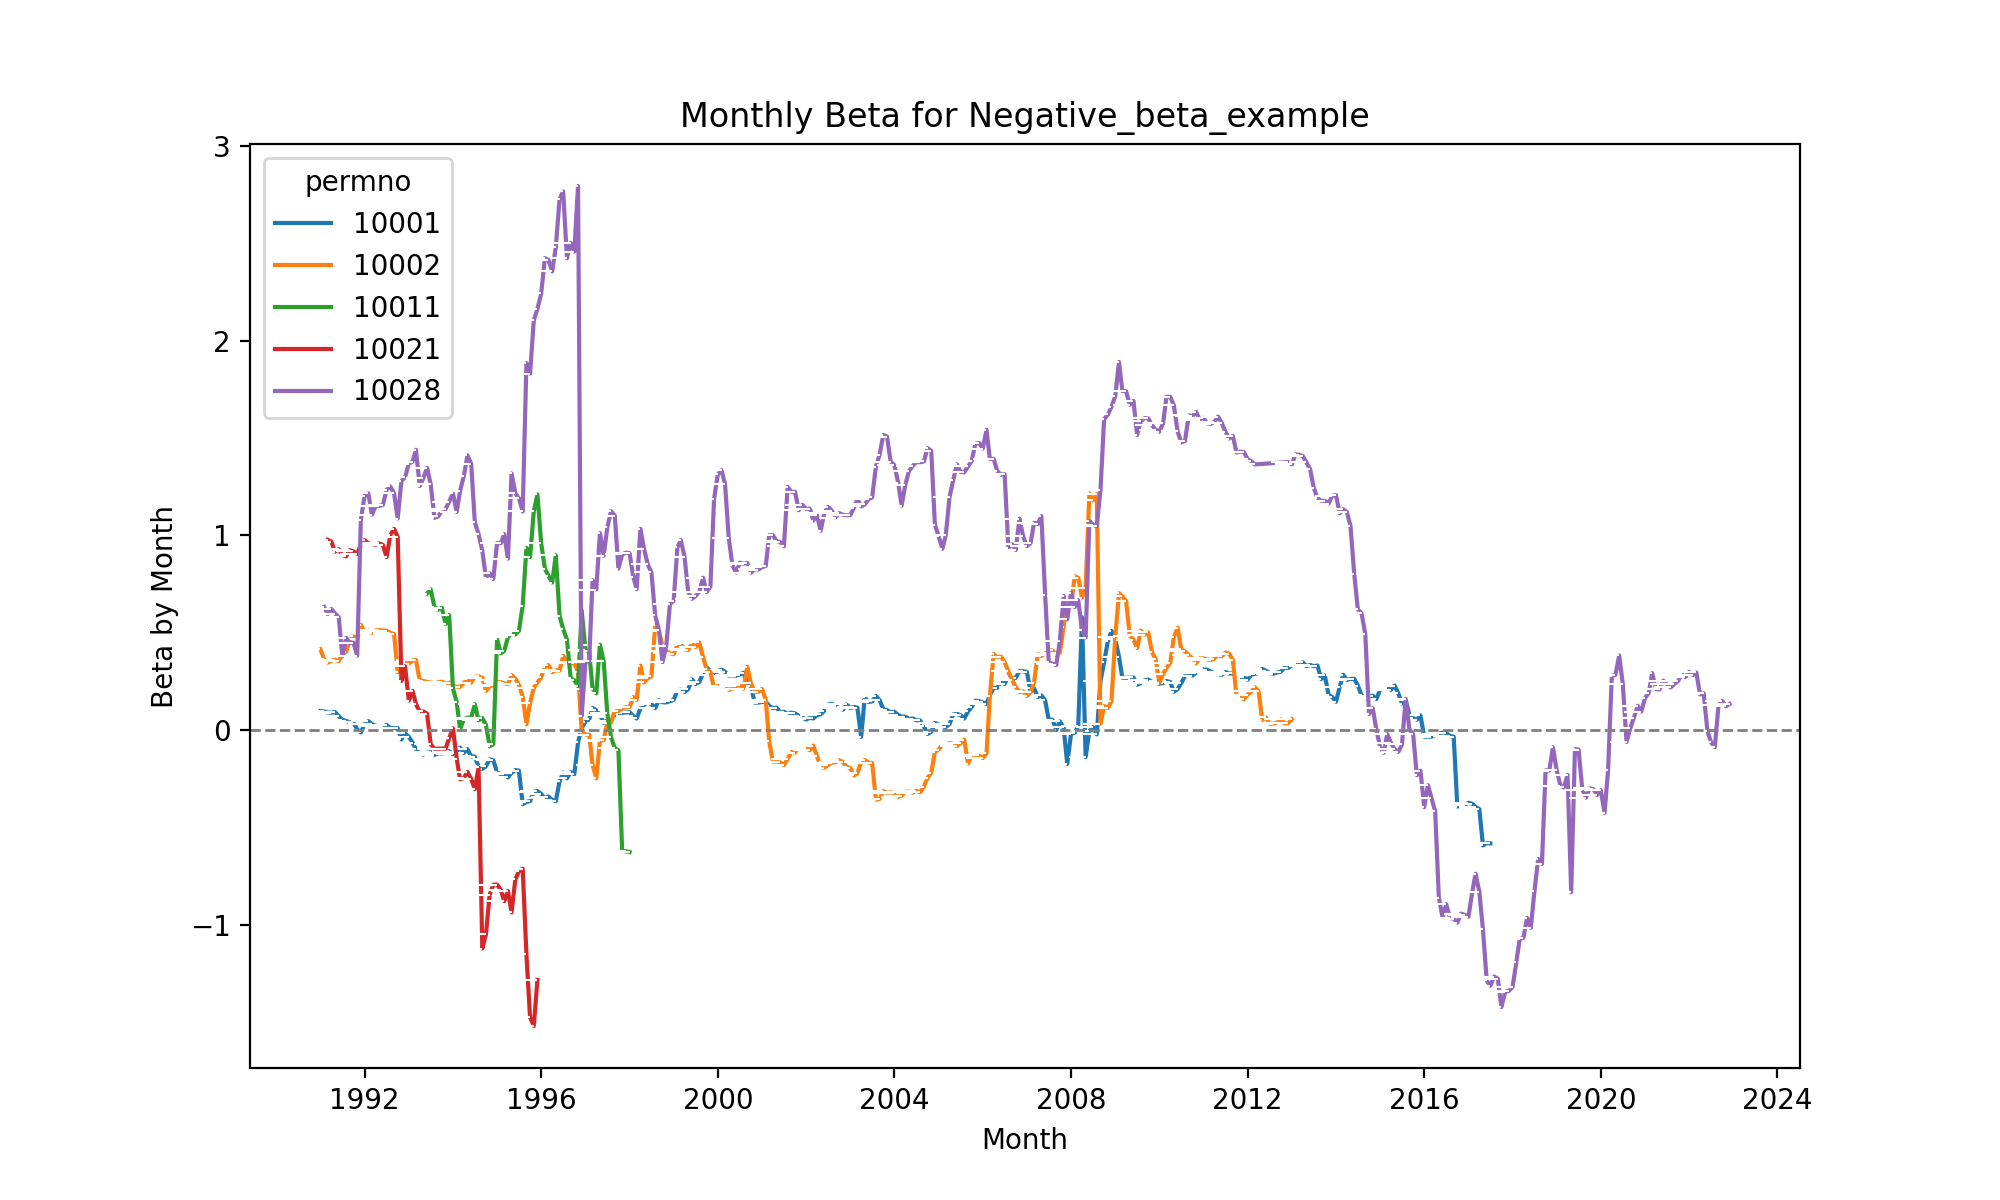

In [37]:
# 绘制月度beta走势图
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='beta_monthly', hue='permno', data=Negative_beta_example,
             marker=False, linestyle='solid')
plt.title('Monthly Beta for Negative_beta_example')
plt.xlabel('Month')
plt.ylabel('Beta by Month')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.legend(title='permno', loc='upper left')
plt.show()

可以看到，这些股票在某些月份呈现为正的beta，有些月份呈现为负的beta，beta的变化幅度较大。

#### 3、计算多因子模型（例如Fama-French3因子模型）的beta估计值。

In [38]:
# 根据需求重新导入数据
three_factors_ff3_monthly = pd.read_csv('factors_ff3_monthly.csv')
crsp_monthly = pd.read_csv('crsp_monthly.csv',usecols=['permno','month','ret_excess'])
merged_dataff3_monthly = pd.merge(crsp_monthly, three_factors_ff3_monthly, how='left', on='month')
merged_dataff3_monthly

,permno,month,ret_excess,mkt_excess,smb,hml,rf
0,10000,1986-02-01 00:00:00,-0.262443,0.0713,-0.0054,-0.0072,0.0053
1,10000,1986-03-01 00:00:00,0.359385,0.0488,-0.0059,-0.0039,0.0060
2,10000,1986-04-01 00:00:00,-0.103792,-0.0131,0.0278,-0.0287,0.0052
3,10000,1986-05-01 00:00:00,-0.227556,0.0462,-0.0135,-0.0021,0.0049
4,10000,1986-06-01 00:00:00,-0.010225,0.0103,-0.0096,0.0128,0.0052
...,...,...,...,...,...,...,...
3326361,93436,2022-08-01 00:00:00,-0.074389,-0.0377,0.0140,0.0029,0.0019
3326362,93436,2022-09-01 00:00:00,-0.039489,-0.0935,-0.0081,0.0005,0.0019
3326363,93436,2022-10-01 00:00:00,-0.144468,0.0783,0.0006,0.0801,0.0023
3326364,93436,2022-11-01 00:00:00,-0.147226,0.0460,-0.0352,0.0138,0.0029


In [39]:
# 以苹果公司为例，使用OLS模型拟合线性回归
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess + smb + hml", # 这里的模型变化为对‘mkt_excess’、‘smb’、‘hml’三因子进行多元回归
    data=merged_dataff3_monthly.query("permno == 14593"))
  .fit()
)
print(model_beta.summary())

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     66.44
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           3.60e-36
Time:                        01:46:08   Log-Likelihood:                 401.56
No. Observations:                 504   AIC:                            -795.1
Df Residuals:                     500   BIC:                            -778.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0136      0.005      2.733      0.0

In [40]:
#对所有数据拟合
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess + smb + hml",
    data=merged_dataff3_monthly)
.fit()
)
print(model_beta.summary())

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                 1.189e+05
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:46:34   Log-Likelihood:             1.0997e+06
No. Observations:             3326366   AIC:                        -2.199e+06
Df Residuals:                 3326362   BIC:                        -2.199e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002   9.72e-05      1.898      0.0